In [1]:
import sys
!cp ../input/rapids/rapids.0.13.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.6"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

cp: cannot stat '../input/rapids/rapids.0.13.0': No such file or directory
tar (child): rapids.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
cp: cannot stat '/opt/conda/envs/rapids/lib/libxgboost.so': No such file or directory


In [2]:
!pip install optuna
import cudf
from cuml.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import pandas as pd
import numpy as np
import optuna

In [4]:
df = pd.read_csv("/kaggle/input/gamedata/game_data_levels.csv")

In [5]:
df.head()

,AddMoves,BuyMoreMoves,Churn,DoubleMana,EndType,ExtraMoves,Level,LevelType,LevelVersion,MaxLevel,...,Scores,ServerTime,StartMoves,SubLevel,UsedChangeCar,UsedCoins,UsedMoves,UserID,Variant,WatchedVideo
0,0,0,0,0,Lose,0,80,Saga,6,80,...,2300,2019-01-01 00:00:08,22,50,0,0,22,0UAqFzWsDK4FrUMp48Y3,0,0
1,0,0,0,0,Lose,0,275,Saga,8,275,...,2865,2019-01-01 00:00:14,13,50,0,0,13,tT3QDgAL47D1qXIaSyZP,0,0
2,0,1,0,0,Win,5,4226,Saga,0,4226,...,4560,2019-01-01 00:00:16,21,0,0,27,26,aE1pu1lJo7XBetF5gIRH,0,0
3,0,0,0,0,Lose,0,131,Saga,0,131,...,2970,2019-01-01 00:00:27,13,50,0,0,13,YH7LKBKxJsllLODfU250,0,0
4,0,0,0,0,Lose,0,131,Saga,0,131,...,2180,2019-01-01 00:00:29,17,50,0,0,17,35HyRrY03K6JBO94XfLE,0,0


In [6]:
df['Churn'].value_counts()

0    784503
1      5376
Name: Churn, dtype: int64

In [7]:
df.columns

Index(['AddMoves', 'BuyMoreMoves', 'Churn', 'DoubleMana', 'EndType',
       'ExtraMoves', 'Level', 'LevelType', 'LevelVersion', 'MaxLevel',
       'NextCar', 'Platform', 'PlayTime', 'RollingLosses', 'Scores',
       'ServerTime', 'StartMoves', 'SubLevel', 'UsedChangeCar', 'UsedCoins',
       'UsedMoves', 'UserID', 'Variant', 'WatchedVideo'],
      dtype='object')

In [8]:
len(df.columns)

24

In [9]:
df["ServerTime"] = pd.to_datetime(df["ServerTime"])
df["ServerTime"] = pd.to_datetime(df["ServerTime"], format="%Y-%m-%d")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789879 entries, 0 to 789878
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   AddMoves       789879 non-null  int64         
 1   BuyMoreMoves   789879 non-null  int64         
 2   Churn          789879 non-null  int64         
 3   DoubleMana     789879 non-null  int64         
 4   EndType        789879 non-null  object        
 5   ExtraMoves     789879 non-null  int64         
 6   Level          789879 non-null  int64         
 7   LevelType      789879 non-null  object        
 8   LevelVersion   789879 non-null  int64         
 9   MaxLevel       789879 non-null  int64         
 10  NextCar        789879 non-null  int64         
 11  Platform       789879 non-null  object        
 12  PlayTime       789879 non-null  int64         
 13  RollingLosses  789879 non-null  float64       
 14  Scores         789879 non-null  int64         
 15  

In [11]:
df.head()

,AddMoves,BuyMoreMoves,Churn,DoubleMana,EndType,ExtraMoves,Level,LevelType,LevelVersion,MaxLevel,...,Scores,ServerTime,StartMoves,SubLevel,UsedChangeCar,UsedCoins,UsedMoves,UserID,Variant,WatchedVideo
0,0,0,0,0,Lose,0,80,Saga,6,80,...,2300,2019-01-01 00:00:08,22,50,0,0,22,0UAqFzWsDK4FrUMp48Y3,0,0
1,0,0,0,0,Lose,0,275,Saga,8,275,...,2865,2019-01-01 00:00:14,13,50,0,0,13,tT3QDgAL47D1qXIaSyZP,0,0
2,0,1,0,0,Win,5,4226,Saga,0,4226,...,4560,2019-01-01 00:00:16,21,0,0,27,26,aE1pu1lJo7XBetF5gIRH,0,0
3,0,0,0,0,Lose,0,131,Saga,0,131,...,2970,2019-01-01 00:00:27,13,50,0,0,13,YH7LKBKxJsllLODfU250,0,0
4,0,0,0,0,Lose,0,131,Saga,0,131,...,2180,2019-01-01 00:00:29,17,50,0,0,17,35HyRrY03K6JBO94XfLE,0,0


In [12]:
df.nunique()

AddMoves              1
BuyMoreMoves          8
Churn                 2
DoubleMana            1
EndType               4
ExtraMoves            8
Level              6240
LevelType             1
LevelVersion         35
MaxLevel           6230
NextCar               1
Platform              1
PlayTime           2562
RollingLosses       618
Scores             1779
ServerTime       737698
StartMoves           38
SubLevel              4
UsedChangeCar         1
UsedCoins           131
UsedMoves            60
UserID             4770
Variant               4
WatchedVideo          1
dtype: int64

In [13]:
df.describe()

,AddMoves,BuyMoreMoves,Churn,DoubleMana,ExtraMoves,Level,LevelVersion,MaxLevel,NextCar,PlayTime,RollingLosses,Scores,StartMoves,SubLevel,UsedChangeCar,UsedCoins,UsedMoves,Variant,WatchedVideo
count,789879.0,789879.000000,789879.000000,789879.0,789879.000000,789879.000000,789879.000000,789879.000000,789879.0,789879.000000,789879.000000,789879.000000,789879.000000,789879.000000,789879.0,789879.000000,789879.000000,789879.000000,789879.0
mean,0.0,0.045677,0.006806,0.0,0.228383,474.050791,6.794656,474.970051,0.0,127.187226,11.865531,3218.710037,18.936312,36.856572,0.0,1.388419,18.024115,0.088360,0.0
std,0.0,0.240063,0.082218,0.0,1.200317,931.899420,6.546539,931.875899,0.0,291.939344,29.015963,1134.421662,5.250793,22.009010,0.0,5.534455,6.094208,0.328264,0.0
min,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,11.000000,0.0,2.000000,0.000000,0.000000,5.000000,0.000000,0.0,0.000000,-5.000000,0.000000,0.0
25%,0.0,0.000000,0.000000,0.0,0.000000,66.000000,0.000000,67.000000,0.0,84.000000,1.000000,2445.000000,15.000000,0.000000,0.0,0.000000,14.000000,0.000000,0.0
50%,0.0,0.000000,0.000000,0.0,0.000000,142.000000,6.000000,142.000000,0.0,107.000000,3.000000,3050.000000,19.000000,50.000000,0.0,0.000000,18.000000,0.000000,0.0
75%,0.0,0.000000,0.000000,0.0,0.000000,386.000000,10.000000,387.000000,0.0,137.000000,10.000000,3870.000000,22.000000,50.000000,0.0,0.000000,22.000000,0.000000,0.0
max,0.0,7.000000,1.000000,0.0,35.000000,6240.000000,34.000000,6240.000000,0.0,88938.000000,617.000000,11300.000000,42.000000,50.000000,0.0,238.000000,59.000000,3.000000,0.0


In [14]:
def generate_temporal_features(date):
    """Generate temporal features from timestamp string"""

    date = pd.Timestamp(date)

    return pd.Series(
        [
            date.year,
            date.quarter,
            date.is_quarter_start,
            date.is_quarter_end,
            date.month,
            date.is_month_start,
            date.is_month_end,
            date.week,
            date.day,
            date.day_of_year,
            date.day_of_week,
            date.hour,
            date.minute,
        ],
        index=[
            "year",
            "quarter",
            "quarter_start",
            "quarter_end",
            "month",
            "month_start",
            "month_end",
            "week",
            "day",
            "day_in_year",
            "day_of_week",
            "hour",
            "minute",
        ],
    )

In [15]:
new_df = df["ServerTime"].apply(generate_temporal_features)

In [16]:
final_df = pd.concat([df, new_df], axis=1)

In [17]:
final_df.isnull().sum()

AddMoves         0
BuyMoreMoves     0
Churn            0
DoubleMana       0
EndType          0
ExtraMoves       0
Level            0
LevelType        0
LevelVersion     0
MaxLevel         0
NextCar          0
Platform         0
PlayTime         0
RollingLosses    0
Scores           0
ServerTime       0
StartMoves       0
SubLevel         0
UsedChangeCar    0
UsedCoins        0
UsedMoves        0
UserID           0
Variant          0
WatchedVideo     0
year             0
quarter          0
quarter_start    0
quarter_end      0
month            0
month_start      0
month_end        0
week             0
day              0
day_in_year      0
day_of_week      0
hour             0
minute           0
dtype: int64

In [18]:
final_df.nunique()

AddMoves              1
BuyMoreMoves          8
Churn                 2
DoubleMana            1
EndType               4
ExtraMoves            8
Level              6240
LevelType             1
LevelVersion         35
MaxLevel           6230
NextCar               1
Platform              1
PlayTime           2562
RollingLosses       618
Scores             1779
ServerTime       737698
StartMoves           38
SubLevel              4
UsedChangeCar         1
UsedCoins           131
UsedMoves            60
UserID             4770
Variant               4
WatchedVideo          1
year                  1
quarter               2
quarter_start         2
quarter_end           1
month                 4
month_start           2
month_end             2
week                 18
day                  30
day_in_year         118
day_of_week           7
hour                 24
minute               60
dtype: int64

In [19]:
redundant_labels = final_df.nunique()[final_df.nunique() < 2].index
final_df.drop(labels = redundant_labels, axis=1, inplace=True)

In [20]:
y = final_df['Churn']
X = final_df.drop(labels=["UserID", "Churn", "ServerTime"], axis=1)

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789879 entries, 0 to 789878
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   BuyMoreMoves   789879 non-null  int64  
 1   EndType        789879 non-null  object 
 2   ExtraMoves     789879 non-null  int64  
 3   Level          789879 non-null  int64  
 4   LevelVersion   789879 non-null  int64  
 5   MaxLevel       789879 non-null  int64  
 6   PlayTime       789879 non-null  int64  
 7   RollingLosses  789879 non-null  float64
 8   Scores         789879 non-null  int64  
 9   StartMoves     789879 non-null  int64  
 10  SubLevel       789879 non-null  int64  
 11  UsedCoins      789879 non-null  int64  
 12  UsedMoves      789879 non-null  int64  
 13  Variant        789879 non-null  int64  
 14  quarter        789879 non-null  int64  
 15  quarter_start  789879 non-null  bool   
 16  month          789879 non-null  int64  
 17  month_start    789879 non-nul

In [22]:
X.nunique()

BuyMoreMoves        8
EndType             4
ExtraMoves          8
Level            6240
LevelVersion       35
MaxLevel         6230
PlayTime         2562
RollingLosses     618
Scores           1779
StartMoves         38
SubLevel            4
UsedCoins         131
UsedMoves          60
Variant             4
quarter             2
quarter_start       2
month               4
month_start         2
month_end           2
week               18
day                30
day_in_year       118
day_of_week         7
hour               24
minute             60
dtype: int64

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

In [24]:
from sklearn import preprocessing

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

In [26]:
y_train.shape

(552915,)

In [27]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [28]:
best_params = {
    'n_estimators': 360, 'max_depth': 3,
    'split_criterion': 1, 'min_samples_split': 9,
    'min_samples_leaf': 2, 'n_bins': 245,
    'sampling_strategy': 0.8688323236281295,
    'n_components': 19, 'whiten': False,
    'iterated_power': 3,
    'svd_solver': 'randomized'
}

In [29]:
def build_model(best_params):
    # Combine One hot encoding and stadard scaler to form one higher level transformer
    model_hp = [
        "n_estimators",
        "max_depth",
        "split_criterion",
        "min_samples_split",
        "min_samples_leaf",
        "n_bins"
    ]
    smote_params = {
        k: v for (k, v) in best_params.items()
        if k in ["sampling_strategy"]
    }
    rf_params = {
        k: v for (k, v) in best_params.items()
        if k in model_hp
    }
    pca_params = {
        k: v for (k, v) in best_params.items()
        if k not in model_hp + ["sampling_strategy"]
    }
    
    first_transformer = ColumnTransformer(
        transformers = [
            # Transformer name, transformer object, column index the transformer will work on
            ("endTypeEncoder", OneHotEncoder(handle_unknown='infrequent_if_exist'), (1, 4, 13, 14, 15, 17, 18)),
            ("levelEncoder", StandardScaler(), (3, 5, 6, 8)),
        ],
        remainder="passthrough"
    )
    
    second_transformer = ColumnTransformer(
        transformers = [
            # Transformer name, transformer object, column index the transformer will work on
            ("endTypeEncoder", OneHotEncoder(handle_unknown='infrequent_if_exist'), (1, 4, 13, 14, 15, 17, 18)),
            ("levelEncoder", RobustScaler(), (3, 5, 6, 8)),
        ],
        remainder="passthrough"
    )


    model = Pipeline(
        steps = [
            ("transform", FeatureUnion(transformer_list = [
                ("first", first_transformer),
                ("second", second_transformer)
            ])), # Transform data
            ("reduce", PCA(**pca_params)),
            ("tomek", TomekLinks()),
            ("oversample", SMOTETomek(**smote_params)), # Oversample; solve data imbalance
            ("model", RandomForestClassifier(bootstrap=True, **rf_params))
        ]
    )
    
    return model

In [30]:
# Fit on training data
#best_params = study.best_params
model = build_model(best_params)
model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Pipeline(steps=[('transform',
                 FeatureUnion(transformer_list=[('first',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('endTypeEncoder',
                                                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                                  (1,
                                                                                   4,
                                                                                   13,
                                                                                   14,
                                                                                   15,
                                                                                   17,
                                                                                   18)),
                                                                                 ('levelEncoder',
                                                                                  StandardScaler(),
                                                                                  (3,
                                                                                   5,
                                                                                   6,
                                                                                   8))])),
                                                ('second',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('endTypeEncoder',
                                                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                                  (1,
                                                                                   4,
                                                                                   13,
                                                                                   14,
                                                                                   15,
                                                                                   17,
                                                                                   18)),
                                                                                 ('levelEncoder',
                                                                                  RobustScaler(),
                                                                                  (3,
                                                                                   5,
                                                                                   6,
                                                                                   8))]))])),
                ('reduce',
                 PCA(iterated_power=3, n_components=19,
                     svd_solver='randomized')),
                ('tomek', TomekLinks()),
                ('oversample',
                 SMOTETomek(sampling_strategy=0.8688323236281295)),
                ('model', RandomForestClassifier())])

In [31]:
### Train ROC AUC
roc_auc_score(y_train, model.predict(X_train),)

0.6212443227326861

In [32]:
### Test ROC AUC
roc_auc_score(y_test, model.predict(X_test),)

0.6192136316699499

In [33]:
### Train accuracy
accuracy_score(y_train, model.predict(X_train),)

0.7493574961793404

In [34]:
### Test accuracy
accuracy_score(y_test, model.predict(X_test),)

0.7475059502709273

In [35]:
confusion_matrix(y_test, model.predict(X_test))

array([[176343,  59008],
       [   824,    789]])

In [36]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.75      0.85    235351
           1       0.01      0.49      0.03      1613

    accuracy                           0.75    236964
   macro avg       0.50      0.62      0.44    236964
weighted avg       0.99      0.75      0.85    236964



In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

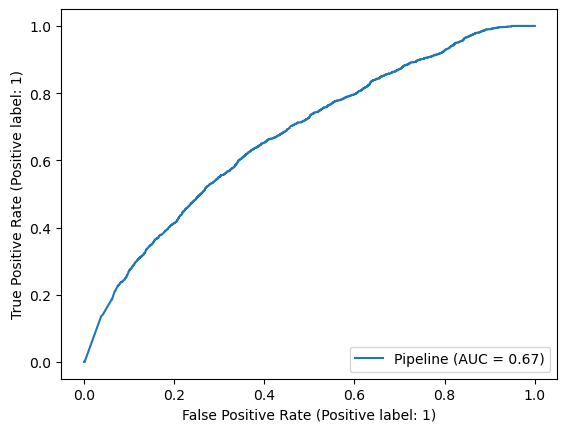

In [38]:
# ROC Curve for test
RocCurveDisplay.from_estimator(model, X = X_test, y = y_test)
plt.show()

In [39]:
from sklearn.metrics import roc_curve

yhat = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.483652, G-Mean=0.630


In [40]:
# ROC AUC score at threshold

t = thresholds[ix]
yhat = (yhat >= t).astype(int)
print(roc_auc_score(y_test, yhat))

0.6297832333968167


### Report Outline

1. Discuss the steps for any data project.
    - Business Understanding
    - Data Understanding
    - Data Preparation
    - Data Modelling
    - Model validation
    - Deployment
<br>
<br>
2. Data Imbalance (Data + Learning Algorithm + Evaluation Metric =  ML Product)
    - Data
        - Data duplication or deduplication
        - Oversampling (SMOTE, ADASYN etcetera)
        - Undersampling (UnderMiss, NearMiss etc)
        - Over-Undersampling
    - Learning Algorithm (Cost-Sensitive Learning Algorithms)
        - Log Reg
        - SVMs
        - Decison Trees (Random Forest etcetera)
        - Make use `class_weight` parameter
    - Evaluation Metric
        - Precision
        - AUC score
        - Recall
        - PR AUC curve

Has Cancer but Doctor says they dont -> Cost high, False Negative
Has does not have Cancer but Doctor says they do -> Cost not as high, False Positive

In [41]:
ohe = OneHotEncoder()

In [42]:
colors = pd.DataFrame(["red", "green", "blue", "red"])

In [43]:
colors

,0
0,red
1,green
2,blue
3,red


In [44]:
ohe.fit(colors)

OneHotEncoder()

In [45]:
ohe.transform(colors).todense()

matrix([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [46]:
colors

,0
0,red
1,green
2,blue
3,red


In [47]:
ohe.categories_

[array(['blue', 'green', 'red'], dtype=object)]

### Next Steps

1. Explore the possibility of generating more features from the `ServerTime` column.
2. Explore more avenues for treating the data imbalance.
3. Do some more EDA to better understand the data features and how they:
    - relate to each other (e.g. correlation)
    - how important they are for final prediction (e.g. feature importance)
    - Remove columns with a cardinality of 1:
        - `LevelType` column. It only contains one value (Saga).
        - `AddMoves` column. It only contains one value (0).
        - `DoubleMana` column. It only contains one value (0).
        - `NextCar` column. It only contains one value (0).

In [48]:
X_train.nunique()

BuyMoreMoves        7
EndType             4
ExtraMoves          7
Level            6169
LevelVersion       35
MaxLevel         6158
PlayTime         2213
RollingLosses     579
Scores           1731
StartMoves         38
SubLevel            4
UsedCoins         123
UsedMoves          58
Variant             4
quarter             2
quarter_start       2
month               4
month_start         2
month_end           2
week               18
day                30
day_in_year       118
day_of_week         7
hour               24
minute             60
dtype: int64